# Law, Order, and Algorithms
## Analyzing "stop-and-frisk" policy

In [18]:
# Load packages
library(tidyverse)
library(glue)
library(ROCR)

theme_set(theme_bw())

## Background

"Stop-and-frisk" is a police practice of temporarily detaining, questioning, and at times searching civilians on the street for weapons and other contraband.

In New York City, between 2003 and 2013, over 100,000 stops were made per year, with 685,724 people being stopped at the height of the program in 2011. The vast majority of those stopped were African-American or Latino, raising concerns of racial bias. You can read more about this [here](https://en.wikipedia.org/wiki/Stop-and-frisk_in_New_York_City).

In this section, we will work with a sample of stops in NYC made between 2007-2013, recorded on a [UF-250 form](https://www.prisonlegalnews.org/news/publications/blank-uf-250-form-stop-question-and-frisk-report-worksheet-nypd-2016/) to explore whether we are able to produce a better, statistically driven frisk policy.

In [38]:
# Load data
stops <- read_rds(file = "../data/sqf_sample.rds")

# Preprocess the data
cols_to_keep <- c('found_weapon', 'frisked', 'suspected_crime',
                  'precinct',
                  'suspect_race', 'suspect_sex', 'suspect_build',
                  'month', 'day',
                  'stopped_bc_furtive', 'stopped_bc_other', 'stopped_bc_object', 'stopped_bc_drugs', 'stopped_bc_violent', 
                  'stopped_bc_lookout', 'stopped_bc_clothing', 'stopped_bc_casing', 'stopped_bc_bulge', 'stopped_bc_desc',
                  'inside_outside', 'location_housing',
                  'additional_highcrime', 'additional_investigation', 'additional_proximity', 'additional_direction', 'additional_other',
                  'additional_associating', 'additional_sights', 'additional_time', 'additional_evasive', 'additional_report',
                  'radio_run', 'officer_uniform',
                  'suspect_height', 'suspect_weight', 'observation_period', 'suspect_age', 'local_hit_rate', 'year')
stops <- stops %>%
  select(any_of(cols_to_keep)) %>%
  # only keep stops with information in all entries
  na.omit() %>%
  mutate(
    # convert non-numerical variables into factors, grouping values occurring < 0.1% of the time into "Other"
    across(where(is.character) | where(is.logical) | where(is.factor), 
           ~ fct_lump(factor(.x), prop = 0.001)),
    # convert outcome into numeric
    across(all_of('found_weapon'), ~ if_else(.x == "TRUE", 1, 0)),
    frisked = as.logical(frisked)
  )

head(stops)

found_weapon,frisked,suspected_crime,precinct,suspect_race,suspect_sex,suspect_build,month,day,stopped_bc_furtive,⋯,additional_evasive,additional_report,radio_run,officer_uniform,suspect_height,suspect_weight,observation_period,suspect_age,local_hit_rate,year
<dbl>,<lgl>,<fct>,<fct>,<fct>,<fct>,<fct>,<ord>,<ord>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>
0,TRUE,cpw,113,black,male,medium,January,Thursday,TRUE,⋯,FALSE,FALSE,FALSE,FALSE,5.833333,180,1,30,0.02293595,2011
0,FALSE,criminal possession of marihuana,23,hispanic,male,medium,August,Friday,TRUE,⋯,FALSE,FALSE,TRUE,TRUE,5.666667,170,2,28,0.09288934,2011
0,FALSE,criminal possession of marihuana,107,hispanic,male,medium,May,Tuesday,TRUE,⋯,TRUE,FALSE,FALSE,TRUE,5.833333,140,2,17,0.07364701,2011
0,TRUE,cpw,44,black,male,thin,June,Thursday,TRUE,⋯,FALSE,TRUE,FALSE,TRUE,5.500000,155,1,23,0.01776445,2012
0,TRUE,cpw,115,hispanic,male,thin,March,Tuesday,FALSE,⋯,TRUE,FALSE,TRUE,TRUE,5.500000,170,2,19,0.02217064,2009
0,TRUE,cpw,23,hispanic,male,thin,November,Sunday,FALSE,⋯,TRUE,FALSE,FALSE,TRUE,5.500000,165,1,15,0.04430036,2009


## The data

This week, we will use the same data frame as last week: `stops`, a sample of stops in NYC, recorded on a 
[UF-250 form][uf250_link].
As a reminder, below is a list of columns in the data, roughly corresponding to the [UF-250 form][uf250_link]:

* Base information regarding stop:
    * `id`, `year`, `date`, `day`, `time`, `hour`, `precinct`, `location_housing`, 
      `suspected_crime`, `lat`, `lon`

* Circumstances which led to the stop:
    * `stopped_bc_object`, `stopped_bc_desc`, `stopped_bc_casing`, `stopped_bc_lookout`, `stopped_bc_clothing`, `stopped_bc_drugs`, `stopped_bc_furtive`, `stopped_bc_violent`, `stopped_bc_bulge`, `stopped_bc_other`
    
* Suspect demographics:
    * `suspect_dob`, `suspect_id_type`, `suspect_sex`, `suspect_race`,
      `suspect_hispanic`, `suspect_age`, `suspect_height`, `suspect_weight`,
      `suspect_hair`, `suspect_eye`, `suspect_build`, `reason_explained`,
      `others_stopped`

* Whether physical force was used:
    * `force_hands`, `force_wall`, `force_ground`, `force_drawn`,
      `force_pointed`, `force_baton`, `force_handcuffs`,
      `force_pepper`, `force_other`

* Was suspect arrested?: `arrested`
    * if yes: `arrested_reason`

* Was summons issued?: `summons_issued`

* Officer in uniform?: `officer_uniform`, `officer_verbal`, `officer_shield`

* Was person frisked?: `frisked`
    * if yes: `frisked_bc_suspected_crime`, `frisked_bc_weapons`, `frisked_bc_attire`, `frisked_bc_actual_crime`, `frisked_bc_noncompliance`, `frisked_bc_threats`, `frisked_bc_prior`, `frisked_bc_furtive`, `frisked_bc_bulge`

* Was person searched?: `searched`,
    * if yes: `searched_hardobject`, `searched_outline`,
      `searched_admission`, `searched_other`

* Was weapon found?: `found_weapon`
    * if yes: `found_gun`, `found_pistol`, `found_rifle`, `found_assault`,
      `found_knife`, `found_machinegun`, `found_other`
      
* Was other contraband found?: `found_contraband`

* Additional circumstances/factors
    * `additional_report`, `additional_investigation`, `additional_proximity`, 
      `additional_evasive`, `additional_associating`, `additional_direction`, 
      `additional_highcrime`, `additional_time`, `additional_sights`, 
      `additional_other`

* Additional reports prepared: `extra_reports`

[uf250_link]: https://www.prisonlegalnews.org/media/publications/Blank%20UF-250%20Form%20-%20Stop%2C%20Question%20and%20Frisk%20Report%20Worksheet%2C%20NYPD%2C%202016.pdf
      

## Checking hit rate for exisiting ploicy

The only legal reason for an officer to conduct a frisk is for officer safety. In other words, the only justified goal of a frisk is to recover weapons under reasonable suspicion.
Therefore, one way to examine the stop-and-frisk threshold is to check the "hit rate" of frisks.
Hit rate is defined as the percent of cases in which a weapon is found among stops for suspicion of criminal possession of a weapon (CPW).
If Black individuals that are frisked have a lower hit rate than white individuals, we have reason to believe the police might have a lower stop-and-frisk threshold for Black individuals.

To check the hit rate for CPW frisks, we shall first restrict our dataset to individuals who are 1) frisked, and 2) have the suspected crime being "cpw"

In [39]:
# Your code here!
# Create a data frame named stops_cpw with only cpw stops
# START solution

stops_cpw <- stops %>%
  filter(frisked, suspected_crime == "cpw")

# END solution

We can then calculate the hit rate for each race group:

In [41]:
# Your code here!
# Create a data frame named stops_cpw with only cpw stops
# START solution

stops_cpw %>%
  group_by(suspect_race) %>%
  summarize(hit_rate = mean(found_weapon))

# END solution

suspect_race,hit_rate
<fct>,<dbl>
asian,0.06054387
black,0.02823581
native american,0.03869048
hispanic,0.04104286
white,0.13705851
other,0.02257903


\[Discuss: what do we see here and what can we say about the stop-and-frisk policy?\]

## Designing a better statistically driven frisk policy

Given this data, can we build a statistically driven frisk policy?
Such a policy can often be constructed in the following two steps:

1. Fit a statistical model to estimate _risk_
1. Set a threshold at which the decision is made.

For the example of deciding whether or not to frisk individuals who have 
been stopped, the _risk_ is the probability that a weapon is recovered
if we were to frisk the individual.
We would like to frisk only the individuals that are most likely to carry a weapon.
Then the policy would be to frisk individuals whose estimated probability of
carrying a weapon is greater than some pre-selected value that we consider optimal.

<!-- [TODO: we want to frisk the highest likely people to have, we frisk those whose probabilit is  > cost ] -->

We will take a closer look at each of these steps below.


### Estimating risk

The only legal reason for an officer to conduct a frisk is for officer
safety. In other words, the only justified goal of a frisk is to recover
weapons.
For an individual $i$, let $X_i$ be all the information we know about the
individual prior to making the frisk decision, and define


$$
Y_i =
\begin{cases}
1 & \textrm{if weapon is found on individual } i \\
0 & \textrm{otherwise}
\end{cases}
$$


Then, the _risk_ we are interested in measuring can be written as

$$
r_i = \Pr(Y_i = 1 ~|~ X_i)
$$



In other words, we wish to estimate the probability that we will recover a 
weapon from an individual, characterized by covariates $X_i$, if we were to 
frisk them.

One way to estimate this probability is to fit a logistic regression on the
subset of individuals who were frisked, to predict whether a weapon will be
found, using all the covariates that an officer observed prior to conducting the
frisk. 

We then split the data into two parts: training set and test set.
We train our logistic regression model using the training set and evaluate it on the test set, so that when evaluting the model, we won't get falsely good performance.
You can read more about this at [this page](https://en.wikipedia.org/wiki/Training,_validation,_and_test_sets).

In [42]:
# Split train-test set
stops_train_cpw <- stops_cpw %>%
  filter(year %in% 2009:2010)
stops_test_cpw <- stops_cpw %>%
  filter(year %in% 2011:2012)

We train and make predictions with the logistic regression model as follows:

In [43]:
# Specifying the model
features <- c('precinct', 'suspect_race')

# We will use all covariates listed in `features` to predict the outcome "found_weapon" 
glm_formula <- reformulate(features, response="found_weapon")

# Train model
glm_fit <- glm(glm_formula, data = stops_train_cpw, family = binomial(link = "logit"))

# Make predictions on the test set
predictions <- predict(glm_fit, newdata = stops_test_cpw, type = "response")

There are many ways to evaluate the logistic regression model's performance.
For binary classification task like the one we are working on (predicting whether or not someone carries a weapon), a common performance metric is [AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic).
A perfect binary prediction model will give an AUC of 1 while a model that is making random guess will produce an AUC of 0.5.

In [44]:
# Helper function to calculate AUC
compute_auc <- function(probs, labels) {
  pred <- prediction(probs, labels)
  auc <- performance(pred, 'auc')
  auc <- unlist(slot(auc, 'y.values'))
  auc
}

compute_auc(probs = predictions, labels = stops_test_cpw$found_weapon)

[1] 0.6871908

Now let's see if we can produce a better logistic regression model by incluiding more covariates in the logistic regression model.

In [47]:
# Your code here!
# Build a better logistic regression model here by including more covariates
# START solution

binary_features <- c('precinct',
                     'suspect_race', 'suspect_sex', 'suspect_build',
                     'month', 'day',
                     'stopped_bc_furtive', 'stopped_bc_other', 'stopped_bc_object', 'stopped_bc_drugs', 'stopped_bc_violent', 
                     'stopped_bc_lookout', 'stopped_bc_clothing', 'stopped_bc_casing', 'stopped_bc_bulge', 'stopped_bc_desc',
                     'inside_outside', 'location_housing',
                     'additional_highcrime', 'additional_investigation', 'additional_proximity', 'additional_direction', 'additional_other',
                     'additional_associating', 'additional_sights', 'additional_time', 'additional_evasive', 'additional_report',
                     'radio_run', 'officer_uniform')
realvalued_features <- c('suspect_height', 'suspect_weight', 'observation_period', 'suspect_age', 'local_hit_rate', 'year')
features <- c(binary_features, realvalued_features)

glm_formula <- reformulate(features, response="found_weapon")
glm_fit <- glm(glm_formula, data = stops_train_cpw, family = binomial(link = "logit"))
predictions <- predict(glm_fit, newdata = stops_test_cpw, type = "response")

# END solution

compute_auc(probs = predictions, labels = stops_test_cpw$found_weapon)

[1] 0.8104031

In [78]:
stops_test_cpw %>%
  filter(suspect_race %in% c("black", "hispanic", "white"), found_weapon_pred > 0.4) %>%
  group_by(suspect_race) %>%
  summarize(hit_rate = mean(found_weapon))

suspect_race,hit_rate
<fct>,<dbl>
black,0.4315353
hispanic,0.5319865
white,0.6306306


In [79]:
# Add our predictions to the data frame
stops_test_cpw <- stops_test_cpw %>%
  mutate(found_weapon_pred = predictions)

# Mean likelihood of finding a weapon:
overall_hit_rate_weapon <- mean(stops_test_cpw$found_weapon_pred)
overall_hit_rate_weapon

# Proportion of stops with smaller than p ex-ante chance of recovering a weapon
p <- 0.01
stops_test_cpw %>% summarize(prop_stops = mean(found_weapon_pred < p))

[1] 0.03512476

prop_stops
<dbl>
0.2644182


In [81]:
# Your code here!
# START solution
cdf_by_weapon_recovery <- stops_test_cpw %>%
  arrange(found_weapon_pred) %>%
  mutate(p = found_weapon_pred,
         cdf = 1:n() / n())
# END solution

Warning message:
“Removed 1359 row(s) containing missing values (geom_path).”


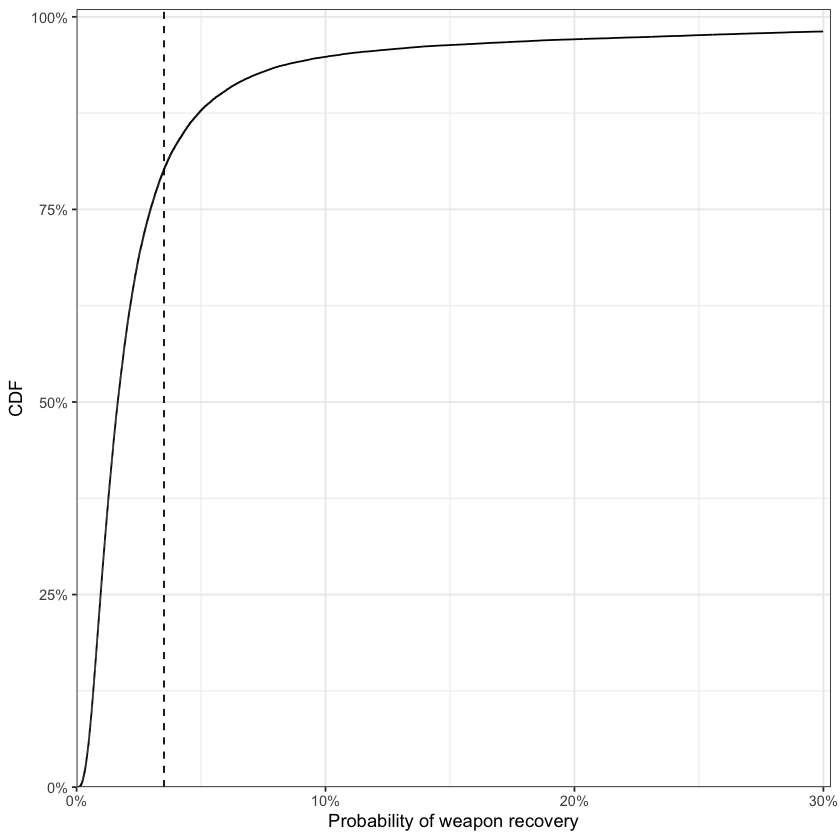

In [82]:
# Figures:
# - CDF by weapon recovery
ggplot(cdf_by_weapon_recovery, aes(x = p, y = cdf)) +
  geom_vline(xintercept=overall_hit_rate_weapon, linetype='dashed') +
  geom_line() +
  scale_x_continuous('Probability of weapon recovery', labels = scales::percent,
                     limits = c(0, 0.3), expand = expansion(mult = c(0, 0.01))) +
  scale_y_continuous('CDF', labels = scales::percent,
                     limits = c(0, 1), expand = expansion(mult = c(0, 0.01))) 

In [84]:
# Your code here!
# START solution
cdf_by_weapon_recovery_by_race <- stops_test_cpw %>%
  filter(suspect_race %in% c("black", "hispanic", "white")) %>%
  mutate(suspect_race = if_else(suspect_race == "white", "white", str_to_title(suspect_race))) %>%
  arrange(found_weapon_pred) %>%
  group_by(suspect_race) %>%
  mutate(p = found_weapon_pred,
         cdf = 1:n() / n())
# END solution

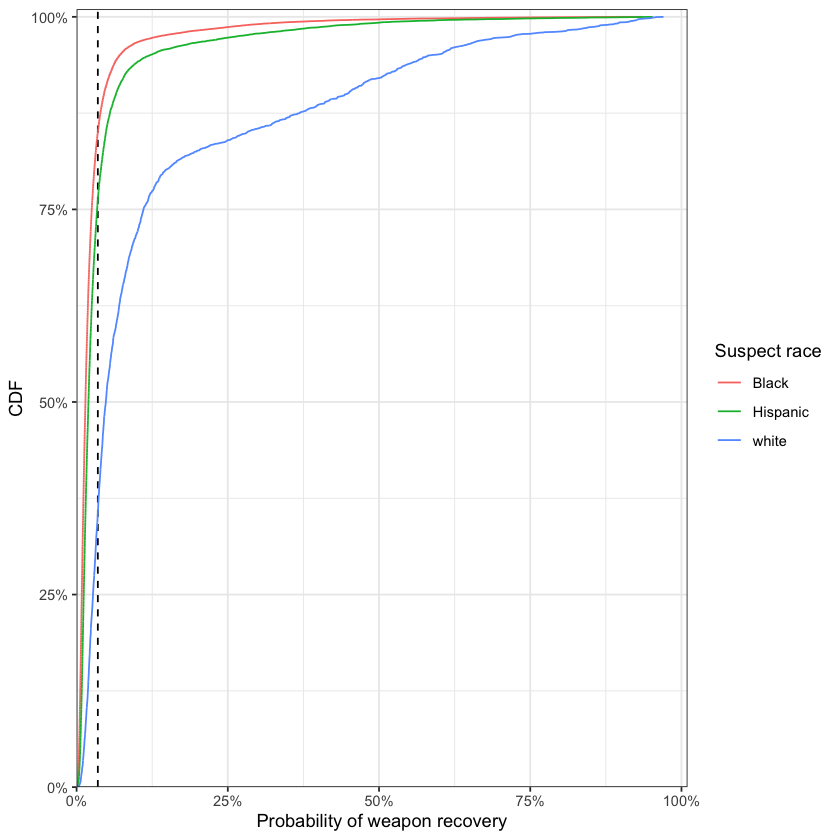

In [85]:
ggplot(cdf_by_weapon_recovery_by_race, aes(x = p, y = cdf, color = suspect_race)) +
  geom_vline(xintercept=overall_hit_rate_weapon, linetype='dashed') +
  geom_line() +
  scale_x_continuous('Probability of weapon recovery', labels = scales::percent,
                     limits = c(0, 1), expand = expansion(mult = c(0, 0.01))) +
  scale_y_continuous('CDF', labels = scales::percent,
                     limits = c(0, 1), expand = expansion(mult = c(0, 0.01))) +
  scale_color_discrete("Suspect race")


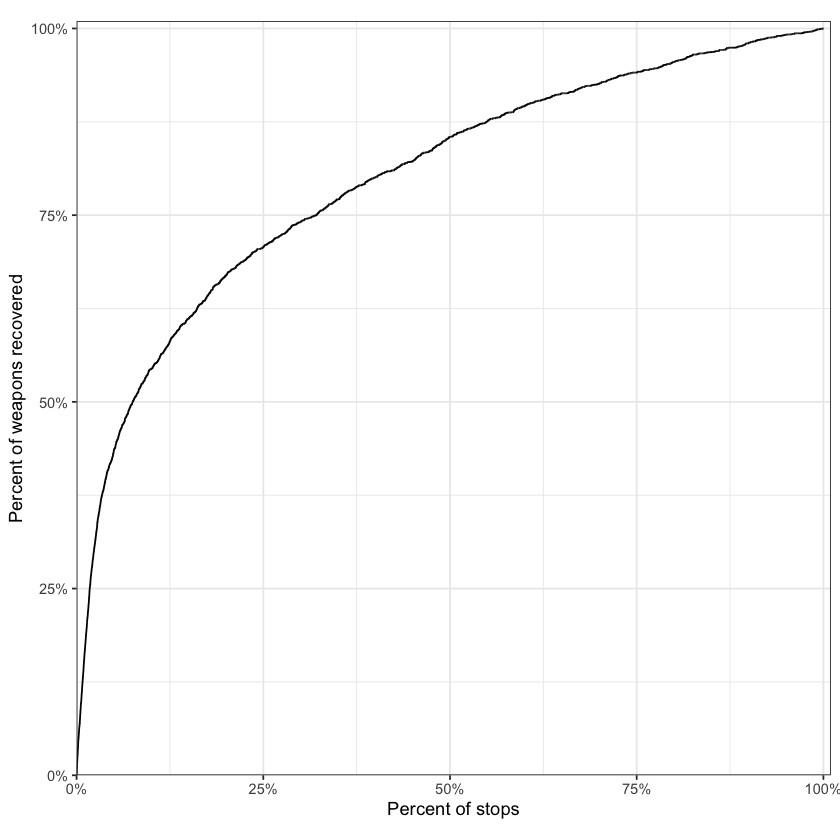

In [86]:
# - Percent weapons recovered by percent of stops
stops_test_cpw %>%
  arrange(desc(found_weapon_pred)) %>%
  mutate(percent_outcome = cumsum(found_weapon)/sum(found_weapon),
         stops = 1:n() / n()) %>%
  ggplot(aes(x = stops, y = percent_outcome)) +
  geom_line() +
  scale_x_continuous('Percent of stops', labels = scales::percent,
                     limits = c(0, 1), expand = expansion(mult = c(0, 0.01))) +
  scale_y_continuous('Percent of weapons recovered', labels = scales::percent,
                     limits = c(0, 1), expand = expansion(mult = c(0, 0.01))) +
  coord_equal()